<a target="_blank" href="https://colab.research.google.com/github/heechul/DeepPicar-v3/blob/devel/RunAll.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>

In [163]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import math
# from skimage import data
from skimage import io
from skimage.exposure import match_histograms

In [164]:
# input image resolution to the DNN model (smaller than the original dataset image resolution: 320x240x3)
img_width = 160
img_height = 66
img_channels = 3

model_name = "model_opt"
model_file = "models/{}-{}x{}x{}".format(model_name[6:], img_width, img_height, img_channels)

In [165]:
import requests 
import os
import zipfile

dataset_dir = "dataset"
dataset_zipfile = 'labtrack-leftonly-RTCSA22.zip' # 'Dataset-kucsl-Aug2022-zero.zip' # 'labtrack-leftonly-RTCSA22.zip' # 'Dataset.zip'
RunningInCOLAB = 'google.colab' in str(get_ipython())
force_unzip = False
use_int8 = False

if RunningInCOLAB: 
    print("in colab")
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
        dataset_zipfile = fn  # expecting a zip file to be uploaded. 
else:
    print ("not in colab")
    # RPI_IP=None # replace this with the IP address of your raspberry pi 
    # if RPI_IP is not None:
    #     URL="http://"+RPI_IP+":8000/"+dataset_zipfile
    #     filename=URL.split('/')[-1]
    #     r = requests.get(URL)
    #     open(filename, 'wb').write(r.content)

# if not os.path.isfile(dataset_zipfile):
#     default_dataset_URL = "https://raw.githubusercontent.com/heechul/DeepPicar-v3/devel/Dataset-kucsl-Apr2022.zip"    
#     print ("No existing dataset. download from ", default_dataset_URL)
#     r = requests.get(default_dataset_URL)
#     open(dataset_zipfile, 'wb').write(r.content)

if not os.path.isdir(dataset_dir) or force_unzip==True:
    print ('unzip %s into %s folder' % (dataset_zipfile, dataset_dir))
    zip_ref = zipfile.ZipFile(dataset_zipfile)
    zip_ref.extractall(dataset_dir)

not in colab


In [166]:
# Train/test data lists
imgs = []
vals = []

def rad2deg(rad):
    return 180.0 * rad / math.pi
def deg2rad(deg):
    return math.pi * deg / 180.0

# scaled crop. return img_height x img_width image
def get_image(img):
    orig_h, orig_w, _ = img.shape
    scaled_h = int(orig_h * img_width / orig_w)
    scaled_w = img_width
    # print(scaled_w, scaled_h)
    scaled_img = cv2.resize(img, (scaled_w, scaled_h))
    # print(scaled_img.shape)
    # crop bottom center pixels of the model input size
    startx = int((scaled_w - img_width) * 0.5);
    starty = int((scaled_h - img_height) * 1.0);
    return scaled_img[starty:starty+img_height, startx:startx+img_width,:]

def preprocess(img):
    img = get_image(img)
    # Convert to grayscale and readd channel dimension
    if img_channels == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.reshape(img, (img_height, img_width, img_channels))
    img = img.astype(np.float32) / 255.0
    if use_int8 == True:
        img = np.round(img * 255.0 - 128).astype(np.int8)
    return img

import glob
for vid_file_path in glob.iglob(f'{dataset_dir}/*.avi'):
    csv_file_path = vid_file_path.replace('video', 'key').replace('avi', 'csv')
    print(vid_file_path, csv_file_path)
    vid = cv2.VideoCapture(vid_file_path)
    df = read_csv(csv_file_path)

    for val in df["wheel"].values:
        ret,img = vid.read()
        img = preprocess(img)
        imgs.append(img)
        vals.append(val)
    print(len(imgs), len(vals))

# Convert lists to numpy arrays and ensure they are of equal length    
imgs = np.asarray(imgs)  # input images
vals = np.asarray(vals)  # steering angles
assert len(imgs) == len(vals)
print("Loaded {} smaples".format(len(imgs)))

dataset/out-video-t85-2.avi dataset/out-key-t85-2.csv
1000 1000
dataset/out-video-t85-1.avi dataset/out-key-t85-1.csv
2000 2000
dataset/out-video-t80-2.avi dataset/out-key-t80-2.csv
3000 3000
dataset/out-video-t80-1.avi dataset/out-key-t80-1.csv
4000 4000
Loaded 4000 smaples


In [167]:
# Split the dataset for train and test 
print("Train/Test")
x_train, x_test, y_train, y_test = train_test_split(imgs, vals, test_size=0.35)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

print("class_weights", class_weights)
class_weights = {i:class_weights[i] for i in range(len(class_weights))}
print("class_weights", class_weights)


Train/Test
class_weights [1.42778693 0.61205273 1.50202195]
class_weights {0: 1.4277869302580999, 1: 0.6120527306967984, 2: 1.5020219526285383}


In [168]:
len(x_train)

2600

In [169]:
from keras import layers

use_depthmodel = False

if use_depthmodel == True: 
  h_len = img_height
  w_len = img_width
  d_len = img_channels

  depth_multiplier = 1.0
  dw_conv_str="1111"
  fc_str="111"
  # depthwise convolution model (doesn't work for some reason!!!)
  model = tf.keras.Sequential()
  
  dw_conv_arr = []
  dw_conv_arr.append(layers.DepthwiseConv2D((5,5), strides=(2, 2)))
  dw_conv_arr.append(layers.Conv2D(round(36 * depth_multiplier), (1, 1), strides=(1, 1)))

  dw_conv_arr.append(layers.DepthwiseConv2D((5,5), strides=(2, 2)))
  dw_conv_arr.append(layers.Conv2D(round(48 * depth_multiplier), (1, 1), strides=(1, 1)))

  dw_conv_arr.append(layers.DepthwiseConv2D((3,3), strides=(1, 1)))
  dw_conv_arr.append(layers.Conv2D(round(64 * depth_multiplier), (1, 1), strides=(1, 1)))

  dw_conv_arr.append(layers.DepthwiseConv2D((3,3), strides=(1, 1)))
  dw_conv_arr.append(layers.Conv2D(round(64 * depth_multiplier), (1, 1), strides=(1, 1)))

  fc_arr = []
  fc_arr.append(layers.Dense(round(100 * depth_multiplier), activation='relu'))
  fc_arr.append(layers.Dense(round(50 * depth_multiplier), activation='relu'))
  fc_arr.append(layers.Dense(round(10 * depth_multiplier), activation='relu'))

  # input layer
  model.add(layers.Input(shape=(h_len,w_len,d_len), name='input'))
  model.add(layers.DepthwiseConv2D((5,5), strides=(2, 2), name='dwi'))
  model.add(layers.Conv2D(round(24 * depth_multiplier), (1, 1), strides=(1, 1), name='pwi'))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  # Add Conv2D layers
  # for i in range(len(conv_str)):
  # 	if int(conv_str[i]) == 1:
  # 		model.add(conv2d_arr[i])

  for i in range(0, len(dw_conv_str)):
    if int(dw_conv_str[i]) == 1:
      model.add(dw_conv_arr[i*2])
      model.add(dw_conv_arr[i*2+1])
      model.add(layers.BatchNormalization())
      model.add(layers.ReLU())

  # Add Flatten layer
  model.add(layers.Flatten())

  # Add FC layers
  for i in range(len(fc_str)):
    if int(fc_str[i]) == 1:
      model.add(fc_arr[i])

  # Add final output layer
  model.add(layers.Dense(1, name="output"))

else:
  # original model
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(img_height,img_width,img_channels)))
  model.add(layers.Conv2D(36, (5,5), strides=(2,2), activation='relu'))
  model.add(layers.Conv2D(48, (5,5), strides=(2,2), activation='relu'))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dense(50, activation='relu'))
  model.add(layers.Dense(10, activation='relu'))
  model.add(layers.Dense(1, name="output"))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 31, 78, 24)        1824      
                                                                 
 conv2d_46 (Conv2D)          (None, 14, 37, 36)        21636     
                                                                 
 conv2d_47 (Conv2D)          (None, 5, 17, 48)         43248     
                                                                 
 conv2d_48 (Conv2D)          (None, 3, 15, 64)         27712     
                                                                 
 conv2d_49 (Conv2D)          (None, 1, 13, 64)         36928     
                                                                 
 flatten_9 (Flatten)         (None, 832)               0         
                                                                 
 dense_27 (Dense)            (None, 100)              

In [170]:
print("Quantize Model")
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

print ("Model compile")
q_aware_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(3e-4),
		                loss=tf.keras.losses.MeanSquaredError())
# q_aware_model.summary()

Quantize Model
Model compile


Model fit
Epoch 1/25
21/21 [==============================] - 4s 140ms/step - loss: 0.1226 - val_loss: 0.1209
Epoch 2/25
21/21 [==============================] - 3s 143ms/step - loss: 0.1139 - val_loss: 0.1042
Epoch 3/25
21/21 [==============================] - 3s 129ms/step - loss: 0.1088 - val_loss: 0.0947
Epoch 4/25
21/21 [==============================] - 3s 134ms/step - loss: 0.0937 - val_loss: 0.0878
Epoch 5/25
21/21 [==============================] - 3s 123ms/step - loss: 0.0837 - val_loss: 0.0801
Epoch 6/25
21/21 [==============================] - 3s 123ms/step - loss: 0.0773 - val_loss: 0.0773
Epoch 7/25
21/21 [==============================] - 3s 123ms/step - loss: 0.0690 - val_loss: 0.0681
Epoch 8/25
21/21 [==============================] - 3s 122ms/step - loss: 0.0611 - val_loss: 0.0604
Epoch 9/25
21/21 [==============================] - 3s 138ms/step - loss: 0.0579 - val_loss: 0.0593
Epoch 10/25
21/21 [==============================] - 3s 127ms/step - loss: 0.0526 - val_lo

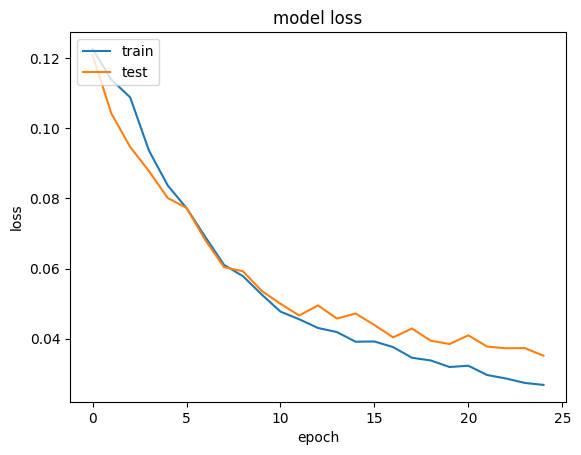

In [171]:
print ("Model fit")
# q_aware_model.reset_states()
history = q_aware_model.fit(x_train, y_train, batch_size=128,
                    epochs=25, validation_data=(x_test, y_test))

# Plot training and validation losses 
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [172]:
angle_thresh=10
# Helper functions for evaluating model accuracy

def get_action(angle_rad):
  degree = rad2deg(angle_rad)
  if degree < angle_thresh and degree > -angle_thresh:
    return "center"
  elif degree >= angle_thresh:
    return "right" 
  elif degree <-angle_thresh:
    return "left"

pred_angle = q_aware_model.predict(x_test)
pred = np.array(list(map(get_action, pred_angle)))
ground = np.array(list(map(get_action, y_test)))
print('Accuracy is %.3f' % np.mean(pred == ground))

44/44 [==============================] - 1s 11ms/step
Accuracy is 0.840


visualization

In [173]:
def plot_image(i, prediction_array, groundtrue_array, img_array):
  angle, predicted_label, groundtrue_label, img = int(rad2deg(pred_angle[i])), prediction_array[i], groundtrue_array[i], img_array[i]
  plt.grid(True)
  plt.xticks([])
  plt.yticks([])
  img = np.squeeze(img)
  if use_int8 == True:
    img = np.round((img + 128.0) / 255.0, 2)
  plt.imshow(img, cmap=plt.cm.binary)
  if predicted_label == groundtrue_label:
    color = 'green'
  else:
    color = 'red'  
  plt.xlabel("Predict:{} ({}) Actual:{}".format(predicted_label,angle,groundtrue_label), color=color)

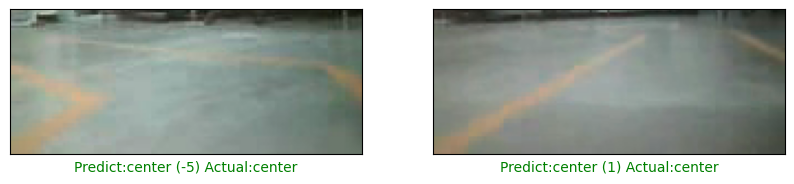

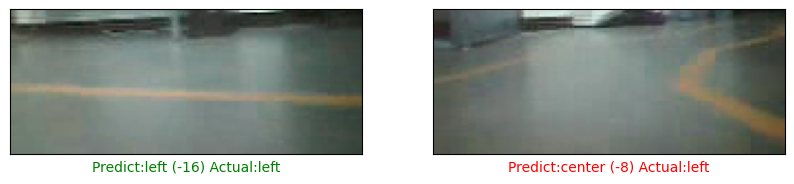

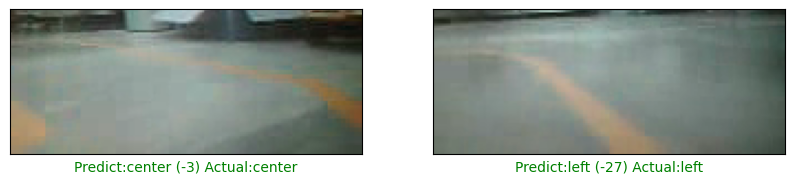

In [174]:
#@title Visualize the outputs { run: "auto" }
index = 200 #@param {type:"slider", min:0, max:244, step:6}
for i in range(3):
  plt.figure(figsize=(10,3))
  plt.subplot(1,2,1)
  plot_image(index + 2*i, pred, ground, x_test)
  plt.subplot(1,2,2)
  plot_image(index + 2*i+1, pred, ground, x_test)
  plt.show()

In [175]:
# Save both the Keras and TFLite models      
print("Model Save")                  
q_aware_model.save(model_file+".h5")

print("TFLite Model")
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# images = tf.cast(x_train, tf.float32)
# def representative_data_gen():
#   for input_value in tf.data.Dataset.from_tensor_slices(images).batch(1).take(100):
#     yield [input_value]

# converter.representative_dataset = representative_data_gen
if use_int8 == True:
    # converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8  # or tf.uint8
    # converter.inference_output_type = tf.int8  # or tf.uint8

quantized_tflite_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

with open(model_file+".tflite", 'wb') as f:
    f.write(quantized_tflite_model)

print (model_file+".tflite is saved. copy this file to the robot")

if RunningInCOLAB: 
    from google.colab import files
    files.download(model_file+".tflite")

Model Save
TFLite Model


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpw6_cgheh/assets


INFO:tensorflow:Assets written to: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpw6_cgheh/assets


input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>
models/opt-160x66x3.tflite is saved. copy this file to the robot


/opt/homebrew/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2023-07-23 20:12:34.331503: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-23 20:12:34.331524: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-23 20:12:34.331698: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpw6_cgheh
2023-07-23 20:12:34.335385: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-07-23 20:12:34.335395: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpw6_cgheh
2023-07-23 20:12:34.349505: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.

generate cc file from tflite model

In [176]:
!xxd -i {model_file}.tflite > {model_file}.cc
print (model_file+".cc is saved. copy this file to the robot")
!cp -v {model_file}.cc src/

models/opt-160x66x3.cc is saved. copy this file to the robot
models/opt-160x66x3.cc -> src/opt-160x66x3.cc
